In [93]:
# 필요한 라이브러리 임포트&설치
# !pip install dbfread
# !pip install haversine
# !pip install sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [94]:
def csv(route):
    k = pd.read_csv('{}'.format(route),encoding='cp949')
    k = k.rename(columns=k.iloc[0]).drop(k.index[0])
    return k

In [95]:
def pklopen(route):
    with open('./가공한데이터/{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
def pklsave(df, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(df, f)

In [96]:
#행정구/동 매칭
dong = pd.read_excel('./data/서울시_행정동_법정동_20200814.xlsx')
#행정동별 거주인구
dong_pop = pklopen('행정동별_거주인구_성별_연령.pickle')
#2015년 결혼상태
married_rate = pd.read_csv('./data/서울시 혼인상태별 인구(15세 이상) 통계.txt', sep='\t')
#맞벌이 가구비율(2012년부터)
both_rate = pd.read_excel('./data/맞벌이 가구비율.xls')
#행정동별 세대수
dong_family = pd.read_csv('./data/행정동별 세대수(17년 12월).txt', sep='\t')
#행정동별 전체인구수
total_ppl = pd.read_pickle('./data/행정동별 전체 인구.pkl')
#귀가시 어른이 맞아주시는 비율
comebackhome = pd.read_csv('./data/귀가_시__부모님_등_어른의_맞이_횟수_20201009190404.csv', encoding='cp949')

In [97]:
#워킹맘 보고서 2018, 워킹맘 초등학생 자녀 평균 하원, 하교시간
working_kids = {'4시이전 하원, 하교(%)':[79.6], '4시~5시 하원, 하교(%)':[14.8], '5시이후 하원, 하교(%)':[5.6]}

In [98]:
working_kids_df = pd.DataFrame(working_kids, index=['초등학생 비율'])
working_kids_df

,"4시이전 하원, 하교(%)","4시~5시 하원, 하교(%)","5시이후 하원, 하교(%)"
초등학생 비율,79.6,14.8,5.6


# 전처리

### 틈새비율(5시 이후 하원,하교 후 집에서 아무도 맞이해주지 못하는 초등학생 비율)

In [99]:
comebackhome = comebackhome.rename(columns=comebackhome.iloc[0]).drop(comebackhome.index[0])
comebackhome['항상 맞이해 주시지 못한다 (%)'] = comebackhome['항상 맞이해 주시지 못한다 (%)'].astype(float)
comebackhome

,특성별(1),특성별(2),사례수 (명),항상 맞이해 주신다 (%),가끔 맞이해 주신다 (%),항상 맞이해 주시지 못한다 (%)
1,전체,소계,8563,66.6,24.3,9.1
2,성별,남자,4318,68.3,23.2,8.4
3,성별,여자,4245,64.8,25.4,9.8
4,교급별,초등1년~초등3년,2847,71.2,19.3,9.4
5,교급별,초등4년~초등6년,2996,63.1,27.7,9.2
6,교급별,중등1년~중등3년,2720,65.4,25.8,8.8
7,지역별,서울,1322,71.1,20.9,8.0
8,지역별,인천/경기,2547,66.2,24.5,9.2
9,지역별,대전/충청/세종/강원,1320,63.3,26.4,10.3
10,지역별,광주/전라/제주,1241,61.3,27.4,11.3


In [100]:
alone_element_rate = comebackhome['항상 맞이해 주시지 못한다 (%)'].iloc[3:5].mean()
alone_element_rate

9.3

In [101]:
working_kids_df

,"4시이전 하원, 하교(%)","4시~5시 하원, 하교(%)","5시이후 하원, 하교(%)"
초등학생 비율,79.6,14.8,5.6


In [102]:
after_five_rate = working_kids_df['5시이후 하원, 하교(%)'].iloc[0]
after_five_rate

5.6

In [103]:
alone_after_five_rate = (alone_element_rate * after_five_rate/100).round(2)
alone_after_five_rate

0.52

### 동별 3040대 맞벌이 부부 & 결혼율 & 동별 0514인구 반영 돌봄필요지수

In [104]:
#동별 코드/구/읍면동명(행정동명)자료
dong = dong[dong['시도명']=='서울특별시']
dong_df = dong[['행정동코드','시군구명']].dropna().drop_duplicates()
dong_df['행정동코드'] = dong_df['행정동코드'].astype(str)
# dong_df.columns = ['행정동코드','시군구명','읍면동명']
dong_df

,행정동코드,시군구명
1,1111000000,종로구
2,1111051500,종로구
12,1111053000,종로구
24,1111054000,종로구
31,1111055000,종로구
...,...,...
763,1174065000,강동구
764,1174066000,강동구
765,1174068500,강동구
766,1174069000,강동구


In [105]:
dong_pop

,ADMI_CD,ADMI_NM,5559세_2,5559세_1,5054세_1,5054세_2,4549세_1,4549세_2,4044세_1,4044세_2,...,2529세_1,2529세_2,2024세_1,2024세_2,1519세_1,1519세_2,1014세_1,1014세_2,0509세_2,0509세_1
1725910,1117051000,후암동,757,709,722,763,745,782,601,653,...,783,748,540,524,422,330,310,270,266,299
1725912,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2631,2201,2346,2649,977,908,792,773,839,880
1725913,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,228,225,184,179,102,114,85,92,94,98
1725917,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,308,212,142,195,59,66,58,41,46,54
1725919,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,501,530,385,471,292,440,230,341,267,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728432,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,498,368,257,283,96,99,72,56,65,74
1728436,1156055000,당산1동,783,774,783,756,799,718,754,701,...,1087,1256,552,708,300,301,220,212,274,253
1728438,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1373,1310,1116,1110,768,726,544,525,477,547
1728439,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,805,720,714,688,666,547,393,460,368,396


In [106]:
#동별 타겟나이 전처리
dong_pop.reset_index(inplace=True)
del dong_pop['index']
dong_pop.columns = ['행정동코드', '행정동명', '5559세_(여)', '5559세_(남)', '5054세_(남)', '5054세_(여)',
       '4549세_(남)', '4549세_(여)', '4044세_(남)', '4044세_(여)', '3539세_(남)', '3539세_(여)',
       '3034세_(남)', '3034세_(여)', '2529세_(남)', '2529세_(여)', '2024세_(남)', '2024세_(여)',
       '1519세_(남)', '1519세_(여)', '1014세_(남)', '1014세_(여)', '0509세_(여)', '0509세_(남)']
dong_pop['0514세 인구'] = dong_pop['0509세_(남)'] + dong_pop['0509세_(여)'] + dong_pop['1014세_(남)']+dong_pop['1014세_(여)']
dong_pop['30대 인구'] = dong_pop['3034세_(남)'] + dong_pop['3034세_(여)'] + dong_pop['3539세_(남)'] + dong_pop['3539세_(여)']
dong_pop['40대 인구'] = dong_pop['4044세_(남)'] + dong_pop['4044세_(여)'] + dong_pop['4549세_(남)'] + dong_pop['4549세_(여)']

dong_pop = dong_pop.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

dong_pop

,행정동코드,행정동명,5559세_(여),5559세_(남),5054세_(남),5054세_(여),4549세_(남),4549세_(여),4044세_(남),4044세_(여),...,2024세_(여),1519세_(남),1519세_(여),1014세_(남),1014세_(여),0509세_(여),0509세_(남),0514세 인구,30대 인구,40대 인구
0,1117051000,후암동,757,709,722,763,745,782,601,653,...,524,422,330,310,270,266,299,1145,2846,2781
1,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2649,977,908,792,773,839,880,3284,6458,6667
2,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,179,102,114,85,92,94,98,369,845,968
3,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,195,59,66,58,41,46,54,199,905,958
4,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,471,292,440,230,341,267,271,1109,2087,2379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,283,96,99,72,56,65,74,267,1219,1243
420,1156055000,당산1동,783,774,783,756,799,718,754,701,...,708,300,301,220,212,274,253,959,4228,2972
421,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1110,768,726,544,525,477,547,2093,4444,5159
422,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,688,666,547,393,460,368,396,1617,3049,3351


In [107]:
#동별 타겟나이 필요분만 추리기
dong_pop_need = dong_pop[['행정동코드','행정동명','0514세 인구','30대 인구','40대 인구']]
dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
dong_pop_need['30대 인구']=dong_pop_need['30대 인구'].astype(int)
dong_pop_need['40대 인구']=dong_pop_need['40대 인구'].astype(int)
dong_pop_need['3040세 인구'] = dong_pop_need['30대 인구'] + dong_pop_need['40대 인구']

del dong_pop_need['30대 인구']
del dong_pop_need['40대 인구']

pop_df = pd.merge(dong_pop_need, dong_df, on='행정동코드')
pop_df

<ipython-input-107-89af5f5390e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
<ipython-input-107-89af5f5390e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
<ipython-input-107-89af5f5390e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [108]:
#결혼율 전처리
married_rate = married_rate.rename(columns=married_rate.iloc[1]).drop(married_rate.index[:2])
married_rate_need = married_rate.iloc[:, :7]
del married_rate_need['기간']
married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub(',','', x))#.astype(int)

married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub('-','0', x)).astype(int)

married_rate_need

C:\anaconda3\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,자치구,연령별,계,유배우,사별,이혼
2,합계,합계,8393832,4481669,519388,417869
3,합계,15~19,543220,305,83,17
4,합계,20~24,681323,6832,243,397
5,합계,25~29,721164,76824,200,1490
6,합계,30~34,821484,352439,403,7422
...,...,...,...,...,...,...
413,강동구,65~69,19697,15001,3021,1473
414,강동구,70~74,13382,9120,3359,740
415,강동구,75~79,8294,4568,3338,302
416,강동구,80~84,4802,1726,2885,147


In [109]:
#구별 결혼율
age30=married_rate_need['연령별'] == '30~34'
age35=married_rate_need['연령별'] == '35~39'
age40=married_rate_need['연령별'] == '40~44'
age45=married_rate_need['연령별'] == '45~49'
age_need = pd.concat([married_rate_need[age30].iloc[:,0].reset_index(), married_rate_need[age30].iloc[:,2:].reset_index() + married_rate_need[age35].iloc[:,2:].reset_index() + married_rate_need[age40].iloc[:,2:].reset_index() + married_rate_need[age45].iloc[:,2:].reset_index()], axis=1)
del age_need['index']
age_need['결혼율'] = 100*(age_need['유배우']/age_need['계']).round(4)
married_rate_gu_df = age_need[['자치구','결혼율']]
married_rate_gu_df.columns = ['시군구명','3040대 결혼율']
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,63.46
1,종로구,58.89
2,중구,55.72
3,용산구,59.37
4,성동구,62.81
5,광진구,59.39
6,동대문구,60.47
7,중랑구,59.82
8,성북구,66.26
9,강북구,57.55


In [110]:
pop_df

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [111]:
#동별 2인이상 가구 전체 수
dong_family_need = dong_family[['행정동','자치구','전체세대수','1인세대']]
dong_family_need['전체세대수'] = pd.to_numeric(dong_family_need['전체세대수'].apply(lambda x: re.sub(',','', x)))
dong_family_need['1인세대'] = pd.to_numeric(dong_family_need['1인세대'].apply(lambda x: re.sub(',','', x)))
dong_family_need['2인이상세대'] = dong_family_need['전체세대수']-dong_family_need['1인세대']
# dong_family_need['2인이상세대'] = dong_family_need['전체세대수']-dong_family_need['1인세대']
dong_family_df = dong_family_need[dong_family_need.행정동 !='소계']
dong_family_df = dong_family_df[dong_family_df.행정동 !='합계']
dong_family_df.columns = ['행정동명','시군구명','전체세대수','1인세대수','2인이상세대수']

total_df = pd.merge(dong_family_df, pop_df, on = ['행정동명','시군구명'])
total_df['행정동코드'] = total_df['행정동코드'].astype(str)
total_df.reset_index(inplace=True)
del total_df['index']
total_df.dropna()

<ipython-input-111-fbe8edb47df6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_family_need['전체세대수'] = pd.to_numeric(dong_family_need['전체세대수'].apply(lambda x: re.sub(',','', x)))
<ipython-input-111-fbe8edb47df6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_family_need['1인세대'] = pd.to_numeric(dong_family_need['1인세대'].apply(lambda x: re.sub(',','', x)))
<ipython-input-111-fbe8edb47df6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,행정동명,시군구명,전체세대수,1인세대수,2인이상세대수,행정동코드,0514세 인구,3040세 인구
0,사직동,종로구,4414,2061,2353,1111053000,704,2903
1,삼청동,종로구,1414,721,693,1111054000,165,748
2,부암동,종로구,4325,1623,2702,1111055000,815,2884
3,평창동,종로구,7510,2393,5117,1111056000,1413,5063
4,무악동,종로구,3024,708,2316,1111057000,925,2558
...,...,...,...,...,...,...,...,...
419,둔촌1동,강동구,888,382,506,1174069000,11,78
420,둔촌2동,강동구,11126,3249,7877,1174070000,2049,8081
421,암사1동,강동구,16345,6031,10314,1174057000,2453,11243
422,천호2동,강동구,17305,7991,9314,1174061000,1710,11353


In [112]:
both_rate = both_rate.rename(columns=both_rate.iloc[2]).drop(both_rate.index[2]).fillna(0)
both_rate.reset_index(inplace=True)
both_rate.columns = ['index','연령','유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율',
    '유배우가구', '맞벌이가구','비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구',
    '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구',
    '맞벌이가구', '비율'] 

both_rate_need = pd.concat([both_rate.연령, both_rate.iloc[:,-9:]], axis=1)
both_rate_need.columns=['연령','유배우가구(2016)','맞벌이가구(2016)','비율(2016)','유배우가구(2017)','맞벌이가구(2017)','비율(2017)','유배우가구(2018)','맞벌이가구(2018)', '비율(2018)']
both_rate_df = both_rate_need[['연령','유배우가구(2017)','맞벌이가구(2017)','비율(2017)']].iloc[2:8]
both_rate_df['유배우가구(2017)'] = pd.to_numeric(both_rate_df['유배우가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['맞벌이가구(2017)'] = pd.to_numeric(both_rate_df['맞벌이가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['비율(2017)'] = pd.to_numeric(both_rate_df['비율(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df

,연령,유배우가구(2017),맞벌이가구(2017),비율(2017)
2,전체,12224,5456,44.6
3,15~29세,179,66,36.8
4,30~39세,2015,954,47.3
5,40~49세,3175,1655,52.1
6,50~64세,4604,2240,48.7
7,65세 이상,2251,542,24.1


In [113]:
total_ppl.columns = ['행정동코드','행정동명','시군구명','총거주인구']
total_ppl['행정동코드'] = total_ppl['행정동코드'] + '00'
total_ppl.reset_index(inplace=True)
del total_ppl['index']

total_ppl = total_ppl.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

total_ppl[total_ppl.행정동명=='종로5·6가동']

,행정동코드,행정동명,시군구명,총거주인구
221,1111063000,종로5·6가동,종로구,5340


In [114]:
whole_df = pd.merge(total_df, total_ppl, on=['행정동명','시군구명','행정동코드'])
whole_df = whole_df[['행정동코드','시군구명','행정동명','0514세 인구','3040세 인구','2인이상세대수','총거주인구']]
final_df = pd.merge(whole_df, married_rate_gu_df, on='시군구명')
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89
1,1111054000,종로구,삼청동,165,748,693,2718,58.89
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89
...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26


# 결혼율과 3~40대 인구 곱 

In [115]:
final_df['3040세 기혼인구'] = ((final_df['3040세 인구'] * final_df['3040대 결혼율'])/100).round(0)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0
...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0


In [116]:
#맞벌이 가구수
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2

final_df['3040세 맞벌이 기혼인구'] = (final_df['3040세 기혼인구']*both_3040s/100).round(0)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0
...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0


In [117]:
final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)'] = 100*(final_df['3040세 맞벌이 기혼인구']/final_df['2인이상세대수']).round(2)
final_df['3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구)'] = 100*(final_df['3040세 맞벌이 기혼인구']/final_df['총거주인구']).round(4)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구)
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0,36.0,8.97
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0,32.0,8.06
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0,31.0,8.36
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0,29.0,8.00
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0,32.0,8.61
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0,5.0,9.51
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0,33.0,9.63
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0,35.0,10.14
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0,40.0,10.56


In [118]:
final_df['초등돌봄필요지수(세대별)'] = final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)']*final_df['0514세 인구']
final_df['초등돌봄필요인구지수(인구별)'] = (final_df['3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구)']*final_df['0514세 인구']).round(0)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요인구지수(인구별)
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0,36.0,8.97,25344.0,6315.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0,32.0,8.06,5280.0,1330.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0,31.0,8.36,25265.0,6813.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0,29.0,8.00,40977.0,11304.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0,32.0,8.61,29600.0,7964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0,5.0,9.51,55.0,105.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0,33.0,9.63,67617.0,19732.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0,35.0,10.14,85855.0,24873.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0,40.0,10.56,68400.0,18058.0


# 틈새비율 * 초등돌봄필요지수(인구별)

In [119]:
final_df['틈새돌봄 필요인구지수'] = ((final_df['초등돌봄필요인구지수(인구별)'] * alone_after_five_rate)/100).round(0)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요인구지수(인구별),틈새돌봄 필요인구지수
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0,36.0,8.97,25344.0,6315.0,33.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0,32.0,8.06,5280.0,1330.0,7.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0,31.0,8.36,25265.0,6813.0,35.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0,29.0,8.00,40977.0,11304.0,59.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0,32.0,8.61,29600.0,7964.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0,5.0,9.51,55.0,105.0,1.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0,33.0,9.63,67617.0,19732.0,103.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0,35.0,10.14,85855.0,24873.0,129.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0,40.0,10.56,68400.0,18058.0,94.0


<AxesSubplot:>

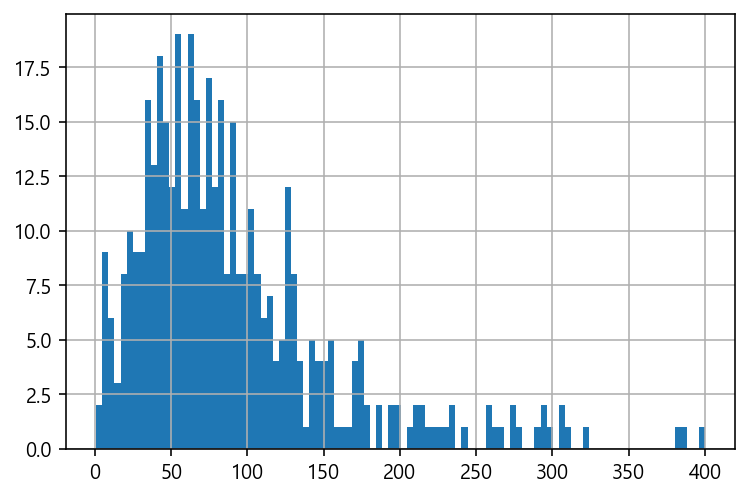

In [120]:
final_df['틈새돌봄 필요인구지수'].hist(bins=100)

<AxesSubplot:>

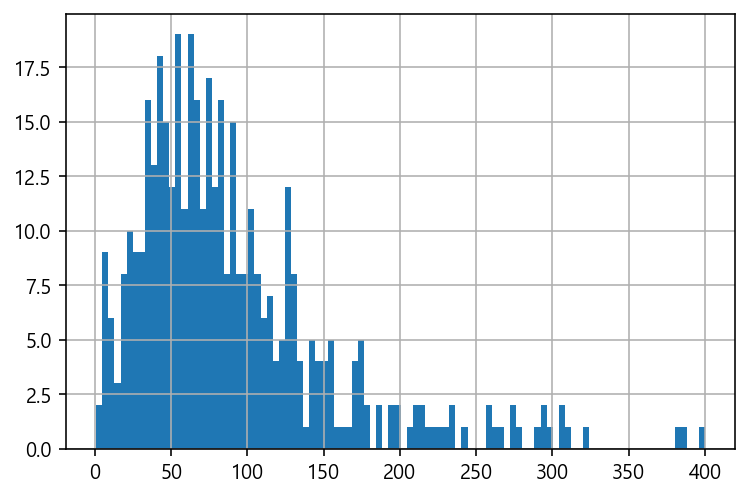

In [121]:
final_df['틈새돌봄 필요인구지수'].hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x21dc83d6be0>,
 'caps': [<matplotlib.lines.Line2D at 0x21dc7e182e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21dc83d6880>],
 'medians': [<matplotlib.lines.Line2D at 0x21dc7e189a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21dc7e18d00>],
 'means': []}

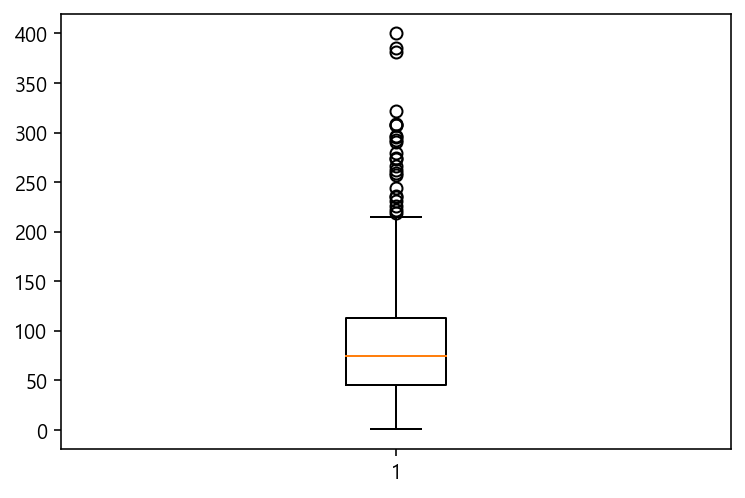

In [122]:
plt.boxplot(final_df['틈새돌봄 필요인구지수'])

In [123]:
final_df.sort_values(by='틈새돌봄 필요인구지수',ascending=False)

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요인구지수(인구별),틈새돌봄 필요인구지수
404,1171067000,송파구,잠실2동,6297,13331,10098,36636,67.50,8998.0,4472.0,44.0,12.21,277068.0,76886.0,400.0
238,1147055000,양천구,목5동,6591,13560,11969,42628,71.04,9633.0,4788.0,40.0,11.23,263640.0,74017.0,385.0
188,1138069000,은평구,진관동,7384,18196,14763,57622,63.29,11516.0,5723.0,39.0,9.93,287976.0,73323.0,381.0
118,1129066000,성북구,길음1동,5305,13021,10398,36678,66.26,8628.0,4288.0,41.0,11.69,217505.0,62015.0,322.0
354,1165065100,서초구,양재1동,5145,14942,12552,45147,70.13,10479.0,5208.0,41.0,11.54,210945.0,59373.0,309.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,1111067000,종로구,창신1동,174,1192,1272,5164,58.89,702.0,349.0,27.0,6.76,4698.0,1176.0,6.0
8,1111063000,종로구,종로5·6가동,146,1333,1110,5340,58.89,785.0,390.0,35.0,7.30,5110.0,1066.0,6.0
19,1114055000,중구,명동,124,841,505,2999,55.72,469.0,233.0,46.0,7.77,5704.0,963.0,5.0
23,1114060500,중구,을지로동,44,481,247,1830,55.72,268.0,133.0,54.0,7.27,2376.0,320.0,2.0


# pt 하기

In [124]:
pt_list = np.percentile(final_df[['틈새돌봄 필요인구지수']],[i*10 for i in range(1,11)]).tolist()
pt_list

[26.300000000000004,
 40.60000000000001,
 51.0,
 62.20000000000002,
 74.5,
 85.79999999999998,
 104.0,
 126.0,
 172.7,
 400.0]

In [125]:
qt_list = [final_df['틈새돌봄 필요인구지수'].quantile(0.25),final_df['틈새돌봄 필요인구지수'].quantile(0.5),final_df['틈새돌봄 필요인구지수'].quantile(0.75),final_df['틈새돌봄 필요인구지수'].quantile(1)]
qt_list

[45.0, 74.5, 113.25, 400.0]

In [126]:
# 초등돌봄틈새필요분위 컬럼
final_df['초등돌봄틈새필요분위'] = 0
final_df.loc[final_df['틈새돌봄 필요인구지수'] <= pt_list[0], '초등돌봄틈새필요분위'] = 1
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[0]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[1]),'초등돌봄틈새필요분위'] = 2
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[1]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[2]),'초등돌봄틈새필요분위'] = 3
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[2]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[3]),'초등돌봄틈새필요분위'] = 4
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[3]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[4]),'초등돌봄틈새필요분위'] = 5
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[4]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[5]),'초등돌봄틈새필요분위'] = 6
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[5]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[6]),'초등돌봄틈새필요분위'] = 7
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[6]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[7]),'초등돌봄틈새필요분위'] = 8
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[7]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[8]),'초등돌봄틈새필요분위'] = 9
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > pt_list[8]) & (final_df['틈새돌봄 필요인구지수'] <= pt_list[9]),'초등돌봄틈새필요분위'] = 10

final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요인구지수(인구별),틈새돌봄 필요인구지수,초등돌봄틈새필요분위
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0,36.0,8.97,25344.0,6315.0,33.0,2
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0,32.0,8.06,5280.0,1330.0,7.0,1
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0,31.0,8.36,25265.0,6813.0,35.0,2
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0,29.0,8.00,40977.0,11304.0,59.0,4
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0,32.0,8.61,29600.0,7964.0,41.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0,5.0,9.51,55.0,105.0,1.0,1
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0,33.0,9.63,67617.0,19732.0,103.0,7
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0,35.0,10.14,85855.0,24873.0,129.0,9
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0,40.0,10.56,68400.0,18058.0,94.0,7


In [127]:
# 초등돌봄필요사분위 컬럼
final_df['초등돌봄틈새필요사분위'] = 0
final_df.loc[final_df['틈새돌봄 필요인구지수'] <= qt_list[0], '초등돌봄틈새필요사분위'] = 0.25
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > qt_list[0]) & (final_df['틈새돌봄 필요인구지수'] <= qt_list[1]),'초등돌봄틈새필요사분위'] = 0.5
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > qt_list[1]) & (final_df['틈새돌봄 필요인구지수'] <= qt_list[2]),'초등돌봄틈새필요사분위'] = 0.75
final_df.loc[(final_df['틈새돌봄 필요인구지수'] > qt_list[2]) & (final_df['틈새돌봄 필요인구지수'] <= qt_list[3]),'초등돌봄틈새필요사분위'] = 1

final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수),3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요인구지수(인구별),틈새돌봄 필요인구지수,초등돌봄틈새필요분위,초등돌봄틈새필요사분위
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,850.0,36.0,8.97,25344.0,6315.0,33.0,2,0.25
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,219.0,32.0,8.06,5280.0,1330.0,7.0,1,0.25
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,844.0,31.0,8.36,25265.0,6813.0,35.0,2,0.25
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,1482.0,29.0,8.00,40977.0,11304.0,59.0,4,0.50
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,748.0,32.0,8.61,29600.0,7964.0,41.0,3,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,25.0,5.0,9.51,55.0,105.0,1.0,1,0.25
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,2621.0,33.0,9.63,67617.0,19732.0,103.0,7,0.75
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,3646.0,35.0,10.14,85855.0,24873.0,129.0,9,1.00
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,3682.0,40.0,10.56,68400.0,18058.0,94.0,7,0.75


In [128]:
alone_need_df = final_df[['행정동코드','시군구명','행정동명','틈새돌봄 필요인구지수','초등돌봄틈새필요분위','초등돌봄틈새필요사분위']]
alone_need_df.columns = [['행정동코드','시군구명','행정동명','틈새돌봄필요 지수','틈새돌봄 필요분위','틈새돌봄 필요사분위']]
alone_need_df

,행정동코드,시군구명,행정동명,틈새돌봄필요 지수,틈새돌봄 필요분위,틈새돌봄 필요사분위
0,1111053000,종로구,사직동,33.0,2,0.25
1,1111054000,종로구,삼청동,7.0,1,0.25
2,1111055000,종로구,부암동,35.0,2,0.25
3,1111056000,종로구,평창동,59.0,4,0.50
4,1111057000,종로구,무악동,41.0,3,0.25
...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,1.0,1,0.25
420,1174070000,강동구,둔촌2동,103.0,7,0.75
421,1174057000,강동구,암사1동,129.0,9,1.00
422,1174061000,강동구,천호2동,94.0,7,0.75


In [130]:
alone_need_df.to_pickle('틈새돌봄필요지수.pkl')
alone_need_df.to_csv('틈새돌봄필요지수.csv')

In [37]:
pd.read_pickle('./data/양천구_초등학생880m_인구.pickle')

,gid,행정동코드,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,경도,위도,geometry
0,다사40aa48ba,1147058000,신월3동,[서울양원초등학교],1,8.0,30.0,21.0,126.822293,37.534999,POINT (126.82229 37.53500)
1,다사40aa48bb,1147058000,신월3동,[서울양원초등학교],1,0.0,0.0,0.0,126.822272,37.537253,POINT (126.82227 37.53725)
2,다사40aa49aa,1147058000,신월3동,"[서울강신초등학교, 서울양원초등학교]",2,0.0,0.0,0.0,126.822252,37.539506,POINT (126.82225 37.53951)
3,다사40aa49ab,1150061100,발산제1동,"[서울강신초등학교, 서울양원초등학교]",2,0.0,0.0,0.0,126.822231,37.541759,POINT (126.82223 37.54176)
4,다사40ab45bb,1147064000,신정3동,[서울신은초등학교],1,0.0,0.0,0.0,126.825345,37.510230,POINT (126.82535 37.51023)
...,...,...,...,...,...,...,...,...,...,...,...
326,다사45bb48bb,1147055000,목5동,"[서울선유초등학교, 서울목원초등학교, 서울경인초등학교]",3,0.0,0.0,0.0,126.887353,37.537608,POINT (126.88735 37.53761)
327,다사45bb49aa,1147055000,목5동,"[서울당산초등학교, 서울목원초등학교, 서울경인초등학교]",3,0.0,0.0,0.0,126.887335,37.539861,POINT (126.88733 37.53986)
328,다사46aa48aa,1147055000,목5동,"[서울선유초등학교, 서울당중초등학교, 서울경인초등학교]",3,0.0,0.0,0.0,126.890238,37.530863,POINT (126.89024 37.53086)
329,다사46aa48ab,1147055000,목5동,"[서울선유초등학교, 서울당중초등학교, 서울경인초등학교]",3,0.0,0.0,0.0,126.890219,37.533116,POINT (126.89022 37.53312)
